# Convergence

In [3]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import os
from ema_workbench import (MultiprocessingEvaluator, ema_logging, RealParameter, ScalarOutcome, Constant,
                           Model, HypervolumeMetric, save_results)
from ema_workbench.em_framework.optimization import (GenerationalBorg, epsilon_nondominated, to_problem, ArchiveLogger,
                                                     EpsilonProgress)

In [4]:
os.chdir('../src')

### BASE CASE

Model definition

In [4]:
from model_zambezi_OPT import ModelZambezi

ZambeziProblem = ModelZambezi()

def model_wrapper(**kwargs):
    input = [kwargs['v' + str(i)] for i in range(len(kwargs))]
    # print('len kwargs is', len(kwargs)) = 230
    Hydropower, Environment, Irrigation = tuple(ZambeziProblem.evaluate(np.array(input)))
    return Hydropower, Environment, Irrigation

# specify model
model = Model('zambeziproblem', function=model_wrapper)

# levers
model.levers = [RealParameter('v' + str(i), -1, 1) for i in range(ZambeziProblem.Nvar)]

# specify outcomes
model.outcomes = [ScalarOutcome('Hydropower', ScalarOutcome.MINIMIZE),  # Minimize, because deficits
                  ScalarOutcome('Environment', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation', ScalarOutcome.MINIMIZE)]


In [5]:
#Problem definition
problem = to_problem(model, searchover="levers")

Run definition

In [5]:
nfe = 35000 #
seeds = 5
run_comment = 'BaseCase'
run_label = f"{run_comment}_{nfe}nfe_{seeds}seed"

os.chdir(f'../runs/{run_label}')
os.getcwd()

'C:\\Users\\whitl\\OneDrive\\Documenten\\MASTER\\Year 2\\THESIS\\16.02.22.Multiobjective\\Multiobjective-multi-reservoir-control-d50e4da0f6a9a9c852b4904e640299adc96714bb\\ZambeziSmashPython\\runs\\BaseCase_35000nfe_5seed'

Change the load archives method of the ArchiveLogger class

In [6]:
import tarfile 
def alternative_load_archives(filename): #cls,
    archives = {}
    with tarfile.open(os.path.abspath(filename)) as fh:
        for entry in fh.getmembers():
            if entry.name.endswith("csv"):
                key = entry.name.split("/")[1][:-4]
                archives[int(key)] = pd.read_csv(fh.extractfile(entry), index_col=0)
    return archives

ArchiveLogger.load_archives = alternative_load_archives

Merge convergences 

In [7]:
convergences = []
for i in range(seeds):
    df = pd.read_csv(f"convergence{i}.csv")
    convergences.append(df)
    #f'convergence{i}' = pd.read_csv(f"{run_name}/convergence{i}.csv") 
    #print(f'convergence{i}')

In [8]:
# Load the archives
all_archives = []
for i in range(seeds):
    archives = ArchiveLogger.load_archives(f"archives/{i}.csv")
        #archives.items()[nfe] =
        #archives = archives.loc[:, ~archives.columns.str.contains('^Unnamed')]
    all_archives.append(archives)


In [9]:
# Create the results list
results_list = []
for i in range(seeds):
    result = pd.read_csv(f"results_seed{i}.csv")
        #archives.items()[nfe] =
        #archives = archives.loc[:, ~archives.columns.str.contains('^Unnamed')]
    results_list.append(result)

In [10]:
# Define the reference list
reference_set = epsilon_nondominated(results_list, [0.05] * len(model.outcomes), problem)  # [0.05]
print('reference_set', reference_set)
print('reference_set type is', type(reference_set))

reference_set            v0        v1        v2        v3        v4        v5        v6  \
0    0.675336 -0.048292  0.191724 -0.495051 -0.413704 -0.186253  0.824178   
1   -0.334144 -0.347669  0.174189 -0.360624  0.057875 -0.487568  0.873310   
2   -0.481857 -0.169152  0.174531 -0.491626 -0.310514 -0.158594  0.997055   
3   -0.304432 -0.347669  0.197275 -0.365813 -0.699917 -0.470512  0.874532   
4   -0.220742 -0.347669  0.174189 -0.383088 -0.348417 -0.228505  0.884093   
..        ...       ...       ...       ...       ...       ...       ...   
485 -0.686959  0.986895 -0.201367  0.548730 -0.927011  0.789848  0.555810   
486 -0.999005  0.933538 -0.045139  0.585608 -0.977488  0.225065  0.426058   
487 -0.261387  0.979955 -0.036479 -0.222254 -0.967020 -0.364243  0.501485   
488 -0.686959  0.986963 -0.201249 -0.196784 -0.927637 -0.300586  0.474237   
489 -0.999537  0.830350 -0.211977 -0.226017 -0.993848 -0.337585  0.401117   

           v7        v8        v9  ...      v223      v224   

In [11]:
#Define the hypervolumemetric
hv = HypervolumeMetric(reference_set, problem)

In [12]:
# Calculate the metrics
metrics_by_seed = []
for archives in all_archives:
    metrics = []
    for nfe, archive in archives.items():
        scores = {
            "hypervolume": hv.calculate(archive),
            "nfe": int(nfe),
        }
        metrics.append(scores)
    metrics = pd.DataFrame.from_dict(metrics)

    # sort metrics by number of function evaluations
    metrics.sort_values(by="nfe", inplace=True)
    metrics_name = 'metrics.csv'
    #metrics.to_csv(os.path.join(cwd, metrics_name))

    metrics_by_seed.append(metrics)

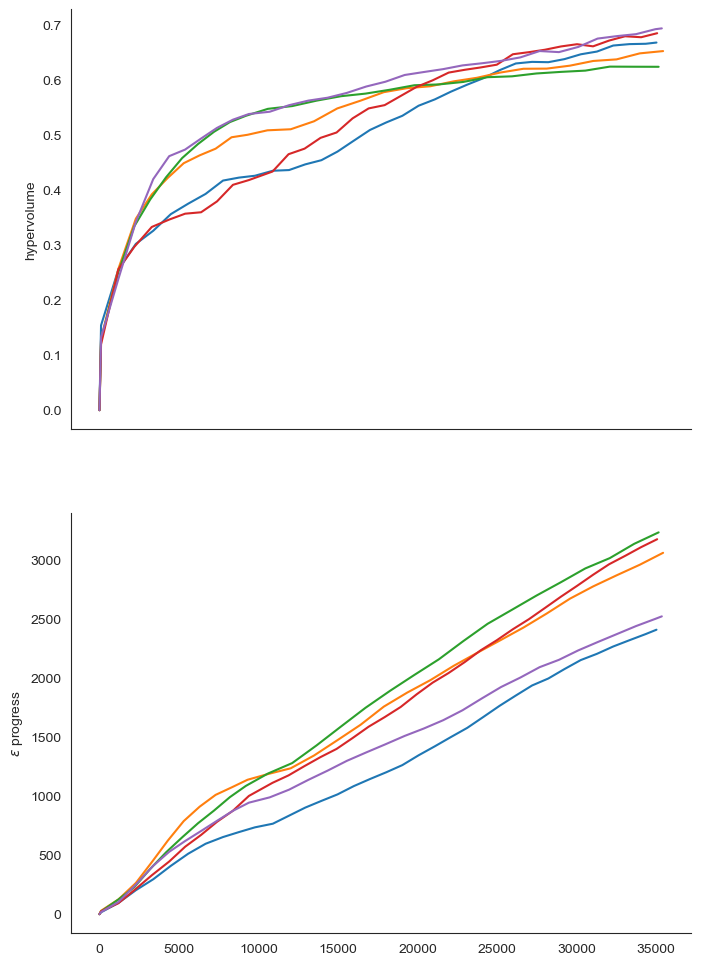

In [13]:
# Visualize convergence metrics
sns.set_style("white")
fig, axes = plt.subplots(nrows=2, figsize=(8, 12), sharex=True)

ax1, ax2 = axes

for metrics, convergence in zip(metrics_by_seed, convergences):
    ax1.plot(metrics.nfe, metrics.hypervolume)
    ax1.set_ylabel("hypervolume")

    ax2.plot(convergence.nfe, convergence.epsilon_progress)
    ax2.set_ylabel("$\epsilon$ progress")
    
sns.despine(fig)

plt.show()

In [17]:
print(metrics_by_seed)

[    hypervolume    nfe
0      0.000000      0
1      0.202744    100
3      0.336843   1189
15     0.398505   2289
27     0.430090   3386
30     0.469896   4486
31     0.495074   5581
32     0.517768   6672
33     0.550582   7770
34     0.557659   8771
35     0.562084   9773
2      0.574197  10905
4      0.575761  11922
5      0.589438  12938
6      0.599546  13957
7      0.616415  14971
8      0.630956  15991
9      0.646668  17011
10     0.652181  18030
11     0.655474  19049
12     0.665930  20069
13     0.673312  21088
14     0.683195  22108
16     0.690413  23127
17     0.699504  24146
18     0.707209  25164
19     0.711761  26184
20     0.714603  27205
21     0.716243  28226
22     0.718679  29244
23     0.721714  30265
24     0.724195  31286
25     0.725832  32307
26     0.727862  33327
28     0.728937  34348
29     0.730050  35028,     hypervolume    nfe
0      0.000000      0
1      0.169956    100
3      0.338378   1192
12     0.458609   2289
20     0.517175   3290
23     0.

### IRRIGATION CASE

In [5]:
from model_zambezi_OPT import ModelZambezi

ZambeziProblem = ModelZambezi()

def model_wrapper(**kwargs):
    input = [kwargs['v' + str(i)] for i in range(len(kwargs))]
    Hydropower, Environment, Irrigation, Irrigation2, Irrigation3, Irrigation4, Irrigation5, Irrigation6, Irrigation7, \
        Irrigation8, Irrigation9 = tuple(ZambeziProblem.evaluate(np.array(input)))
    return Hydropower, Environment, Irrigation, Irrigation2, Irrigation3, Irrigation4, Irrigation5, Irrigation6, \
        Irrigation7, Irrigation8, Irrigation9
# specify model
model = Model('zambeziproblem', function=model_wrapper)

# levers
model.levers = [RealParameter('v' + str(i), -1, 1) for i in range(ZambeziProblem.Nvar)]

# specify outcomes
model.outcomes = [ScalarOutcome('Hydropower', ScalarOutcome.MINIMIZE),  # Minimize, because deficits
                  ScalarOutcome('Environment', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation2', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation3', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation4', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation5', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation6', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation7', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation8', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation9', ScalarOutcome.MINIMIZE),
                  ]


In [6]:
#Problem definition
problem = to_problem(model, searchover="levers")

Run definition

In [7]:
nfe = 500 #
seeds = 1
run_comment = 'irr_test'
run_label = f"{run_comment}_{nfe}nfe_{seeds}seed"

os.chdir(f'../runs/{run_label}')
os.getcwd()

'C:\\Users\\whitl\\OneDrive\\Documenten\\MASTER\\Year 2\\THESIS\\16.02.22.Multiobjective\\Multiobjective-multi-reservoir-control-d50e4da0f6a9a9c852b4904e640299adc96714bb\\ZambeziSmashPython\\runs\\irr_test_500nfe_1seed'

Change the load archives method of the ArchiveLogger class

In [8]:
import tarfile 
def alternative_load_archives(filename): #cls,
    archives = {}
    with tarfile.open(os.path.abspath(filename)) as fh:
        for entry in fh.getmembers():
            if entry.name.endswith("csv"):
                key = entry.name.split("/")[1][:-4]
                archives[int(key)] = pd.read_csv(fh.extractfile(entry), index_col=0)
    return archives

ArchiveLogger.load_archives = alternative_load_archives

Merge convergences 

In [9]:
convergences = []
for i in range(seeds):
    df = pd.read_csv(f"convergence{i}.csv")
    convergences.append(df)
    #f'convergence{i}' = pd.read_csv(f"{run_name}/convergence{i}.csv") 
    #print(f'convergence{i}')

In [10]:
# Load the archives
all_archives = []
for i in range(seeds):
    archives = ArchiveLogger.load_archives(f"archives/{i}.csv")
        #archives.items()[nfe] =
        #archives = archives.loc[:, ~archives.columns.str.contains('^Unnamed')]
    all_archives.append(archives)


In [11]:
# Create the results list
results_list = []
for i in range(seeds):
    result = pd.read_csv(f"results_seed{i}.csv")
        #archives.items()[nfe] =
        #archives = archives.loc[:, ~archives.columns.str.contains('^Unnamed')]
    results_list.append(result)

In [12]:
# Define the reference list
reference_set = epsilon_nondominated(results_list, [0.05] * len(model.outcomes), problem)  # [0.05]
print('reference_set', reference_set)
print('reference_set type is', type(reference_set))

reference_set           v0        v1        v2        v3        v4        v5        v6  \
0  -0.538182 -0.146845  0.934760 -0.531070  0.369110 -0.691296 -0.614991   
1   0.769015 -0.549924 -0.784913 -0.835107 -0.719118  0.915152 -0.181781   
2  -0.174912  0.056953 -0.091455 -0.052717 -0.147727  0.188175 -0.124289   
3  -0.187347 -0.097563 -0.245486  0.000763  0.309322  0.365167 -0.311619   
4   0.305503 -0.312157  0.309971  0.064084  0.011647  0.246792 -0.170064   
5   0.842795  0.219755 -0.708393 -0.613222 -1.000000  0.589365 -0.626320   
6   0.321253 -1.000000  0.977698 -0.999042  0.361799  0.323818  1.000000   
7   0.215458 -0.243572  0.067066 -0.578259  0.093880  0.269959  0.360441   
8  -0.955471 -0.317381 -0.994794  0.588190 -0.017047 -0.202066  0.383000   
9   0.842795  0.219755  0.058553 -0.613222 -1.000000  0.589365 -0.631528   
10  0.960140  0.458702  1.000000 -0.613498  0.535800  0.693751  1.000000   
11  0.471712  0.260216  0.168334 -0.881880  0.746556  0.795400  0.554298  

In [13]:
#Define the hypervolumemetric
hv = HypervolumeMetric(reference_set, problem)

In [14]:
# Calculate the metrics
metrics_by_seed = []
for archives in all_archives:
    metrics = []
    for nfe, archive in archives.items():
        scores = {
            "hypervolume": hv.calculate(archive),
            "nfe": int(nfe),
        }
        metrics.append(scores)
    metrics = pd.DataFrame.from_dict(metrics)

    # sort metrics by number of function evaluations
    metrics.sort_values(by="nfe", inplace=True)
    metrics_name = 'metrics.csv'
    #metrics.to_csv(os.path.join(cwd, metrics_name))

    metrics_by_seed.append(metrics)

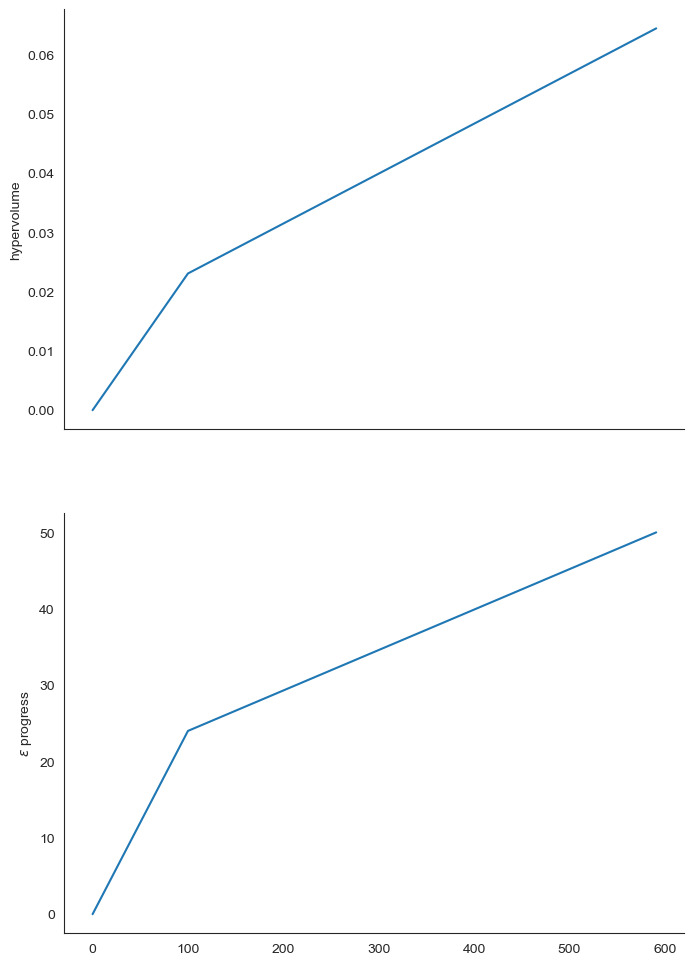

In [15]:
# Visualize convergence metrics
sns.set_style("white")
fig, axes = plt.subplots(nrows=2, figsize=(8, 12), sharex=True)

ax1, ax2 = axes

for metrics, convergence in zip(metrics_by_seed, convergences):
    ax1.plot(metrics.nfe, metrics.hypervolume)
    ax1.set_ylabel("hypervolume")

    ax2.plot(convergence.nfe, convergence.epsilon_progress)
    ax2.set_ylabel("$\epsilon$ progress")
    
sns.despine(fig)

plt.show()